# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
import pandas as pd
import sys
import doubletdetection
import tarfile
import time
from bhtsne import tsne
from sklearn.decomposition import PCA
import phenograph

## Download Data from 10x

In [2]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

--2018-04-20 12:21:25--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2600:9000:203c:4400:1d:87c0:ff40:93a1, 2600:9000:203c:4600:1d:87c0:ff40:93a1, 2600:9000:203c:3400:1d:87c0:ff40:93a1, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2600:9000:203c:4400:1d:87c0:ff40:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  6.48MB/s    in 7.3s    

2018-04-20 12:21:32 (4.88 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



### Load Count Matrix

In [3]:
matrix_path = 'filtered_gene_bc_matrices/GRCh38/matrix.mtx'
raw_counts = doubletdetection.load_mtx(matrix_path)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]

## Run Doublet Detection

Right now, phenograph is a bit talkative, so we capture the output to avoid lots of text

In [4]:
# %%capture

clf = doubletdetection.BoostClassifier(new_lib_as=None, n_iters=50)

start = time.time()
doublets = clf.fit(raw_counts).predict()
end = time.time()


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 31], with sizes: [119, 1136, 774, 758, 637, 632, 628, 563, 486, 473, 381, 370, 347, 316, 302, 301, 291, 249, 232, 226, 214, 190, 166, 120, 116, 94, 91, 74, 58, 42, 38, 31, 21]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 32], with sizes: [113, 997, 851, 811, 790, 735, 581, 520, 517, 515, 418, 351, 337, 286, 276, 249, 232, 225, 214, 203, 184, 178, 137, 136, 105, 89, 79, 78, 77, 58, 46, 37, 32, 19]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 30], with sizes: [107, 1084, 1052, 938, 801, 736, 618, 509, 497, 441, 427, 336, 315, 283, 264, 237, 230, 217, 198, 191, 166, 159, 127, 117, 81, 71, 69, 64, 41, 39, 31, 30]


Creating downsampled doublets...
Normalizing..

Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 33], with sizes: [154, 1074, 948, 781, 738, 669, 615, 526, 495, 458, 348, 327, 308, 306, 301, 278, 247, 223, 214, 209, 191, 153, 130, 118, 110, 107, 105, 88, 62, 60, 39, 30, 29, 19, 16]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 31], with sizes: [111, 1133, 986, 777, 700, 630, 531, 504, 452, 428, 409, 349, 347, 342, 299, 297, 278, 267, 258, 223, 200, 190, 157, 120, 98, 74, 72, 69, 62, 37, 35, 30, 11]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 31], with sizes: [147, 1103, 928, 849, 804, 752, 702, 525, 512, 448, 419, 344, 339, 300, 286, 255, 246, 228, 222, 162, 120, 115, 111, 99, 96, 78, 65, 64, 62, 39, 29, 14, 13]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clusterin

In [5]:
print('Time elapsed: {} seconds for {} iterations'.format(np.round(end-start, 2), clf.n_iters))

Time elapsed: 1314.36 seconds for 50 iterations


## Visualize Results

### Convergence of Doublet Calls

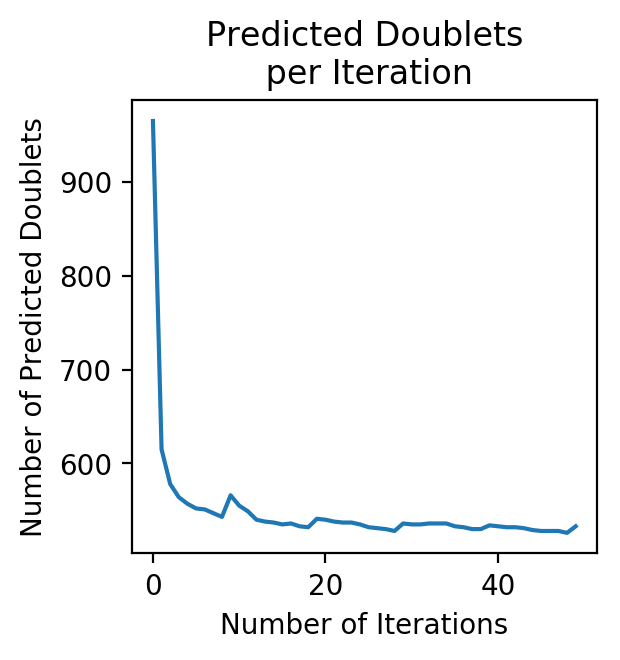

In [6]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True)

### Doublets on TSNE map

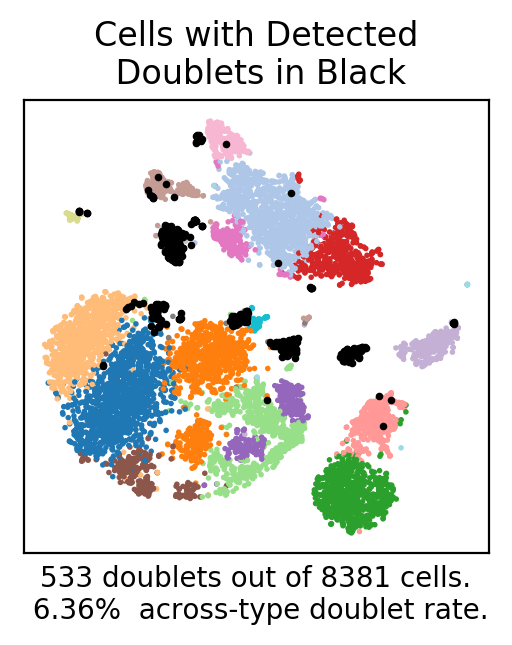

In [7]:
f2, tsne_coords = doubletdetection.plot.tsne(raw_counts, doublets, save='tsne_test.pdf', show=True)